In [1]:
import sys
sys.path.insert(0,'../')
from libs.ssl_task import Classification
from test_utils import CIFARDataModule
import lightning as L
%load_ext autoreload
%autoreload 2
L.seed_everything(7)

Seed set to 7


7

In [2]:
datamodule = CIFARDataModule(batch_size=256)
datamodule.prepare_data()
datamodule.setup('fit')

Files already downloaded and verified
Files already downloaded and verified


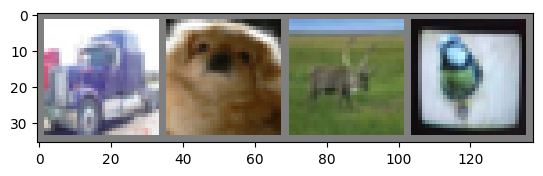

truck dog   deer  bird 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
# functions to show an image

trainloader = datamodule.train_dataloader()

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
batch_size = 4
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [7]:
from lightning.pytorch.callbacks import LearningRateMonitor
from lightning.pytorch.loggers import CSVLogger
import lightning as L
lit = Classification.ClassificationLit(
    encoder_path='tests.test_utils.CIFARResNet',
    encoder_kwargs={},
    task='multiclass',
    num_classes=10,
    optimizer_path='torch.optim.Adamax',
    optimizer_kwargs={'lr': 0.005, 'weight_decay': 0.001},
)

trainer = L.Trainer(max_epochs=5, max_steps=-1,
                    logger=CSVLogger(save_dir="."),
                    callbacks=[LearningRateMonitor(logging_interval="step")],)
trainer.fit(lit, datamodule)

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type        | Params | Mode 
------------------------------------------------
0 | encoder | CIFARResNet | 11.2 M | train
------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.696    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


optimizer Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.005
    maximize: False
    weight_decay: 0.001
)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


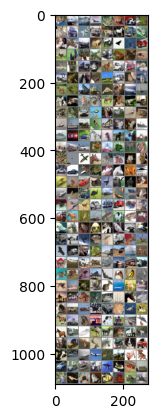

GroundTruth:  cat   ship  ship  plane frog  frog  car   frog  cat   car   plane truck dog   horse truck ship  dog   horse ship  frog  horse plane deer  truck dog   bird  deer  plane truck frog  frog  dog   deer  dog   truck bird  deer  car   truck dog   deer  frog  dog   frog  plane truck cat   truck horse frog  truck ship  plane cat   ship  ship  horse horse deer  frog  horse cat   frog  cat   frog  bird  car   bird  cat   horse bird  frog  ship  ship  plane bird  truck cat   cat   ship  ship  car   car   horse bird  dog   bird  horse ship  truck plane cat   ship  frog  deer  frog  frog  plane plane horse deer  dog   frog  cat   car   car   cat   frog  ship  horse deer  plane frog  bird  car   cat   plane deer  bird  horse ship  cat   car   bird  ship  plane ship  cat   dog   bird  deer  car   ship  truck car   bird  truck horse bird  truck frog  dog   frog  cat   ship  horse frog  bird  dog   bird  ship  truck frog  plane plane dog   bird  truck dog   deer  bird  car   frog  frog  sh

In [50]:
datamodule.setup('test')
testloader = datamodule.test_dataloader()
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(256)))

In [ ]:
outputs = lit.embed(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(256)))

In [53]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = lit.embed(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 81 %


In [54]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = lit.embed(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 84.6 %
Accuracy for class: car   is 91.6 %
Accuracy for class: bird  is 72.5 %
Accuracy for class: cat   is 65.5 %
Accuracy for class: deer  is 79.1 %
Accuracy for class: dog   is 74.1 %
Accuracy for class: frog  is 86.6 %
Accuracy for class: horse is 81.8 %
Accuracy for class: ship  is 89.6 %
Accuracy for class: truck is 89.2 %


,lr-Adamax,train_accuracy_epoch,train_f1_epoch,train_loss_epoch,val_Classifier/accuracy,val_Classifier/f1,val_Classifier/loss
epoch,,,,,,,
NaN,0.005,NaN,NaN,NaN,NaN,NaN,NaN
0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,0.005,NaN,NaN,NaN,NaN,NaN,NaN
0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,0.005,NaN,NaN,NaN,NaN,NaN,NaN


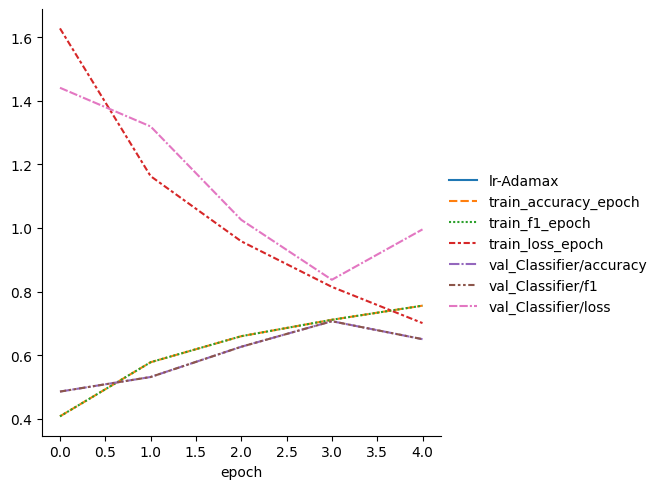

In [8]:
import pandas as pd
import seaborn as sn
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
# drop all columns start with "grad_2.0_norm"
for col in metrics.columns:
    if col.startswith("grad_2.0_norm") or "step" in col:
        del metrics[col]
# del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics, kind="line")

In [9]:
metrics.iloc[-1]

lr-Adamax                      NaN
train_accuracy_epoch       0.75570
train_f1_epoch             0.75570
train_loss_epoch           0.70089
val_Classifier/accuracy        NaN
val_Classifier/f1              NaN
val_Classifier/loss            NaN
Name: 4.0, dtype: float64

In [10]:
metrics.iloc[-2]

lr-Adamax                      NaN
train_accuracy_epoch           NaN
train_f1_epoch                 NaN
train_loss_epoch               NaN
val_Classifier/accuracy    0.65030
val_Classifier/f1          0.65030
val_Classifier/loss        0.99548
Name: 4.0, dtype: float64